<h1> Explore and create ML datasets </h1>

In this notebook, we will explore data corresponding to taxi rides in New York City to build a Machine Learning model in support of a fare-estimation tool. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected.

<div id="toc"></div>

Let's start off with the Python imports that we need.

In [21]:
!pip install folium plotly

     |████████████████████████████████| 7.1 MB 4.8 MB/s eta 0:00:01


In [37]:
from google.cloud import bigquery
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import plotly.express as px

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Write a SQL query to pick up the following fields
<pre>
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
</pre>
from the dataset and explore a small part of the data. Make sure to pick a repeatable subset of the data so that if someone reruns this notebook, they will get the same results.

In [2]:
rawdata = """
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  `nyc-tlc.yellow.trips`
WHERE
  ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N)) = 1
"""

In [3]:
query = rawdata.replace("EVERY_N", "100000")
print(query)
trips = bigquery.Client().query(query).to_dataframe()
print("Total dataset is {} taxi rides".format(len(trips)))
trips[:10]


SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  `nyc-tlc.yellow.trips`
WHERE
  ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1

Total dataset is 10789 taxi rides


pickup_datetime  pickup_longitude  pickup_latitude  \
0 2012-05-05 22:46:05+00:00        -74.009790        40.712483   
1 2010-12-21 13:08:00+00:00        -73.982422        40.739847   
2 2011-12-03 10:28:00+00:00        -73.998822        40.680933   
3 2012-02-21 11:53:00+00:00        -73.953860        40.787055   
4 2009-09-25 03:47:00+00:00        -74.001323        40.727572   
5 2014-05-17 15:15:00+00:00        -73.980682        40.734032   
6 2009-11-01 02:59:23+00:00        -74.006934        40.734067   
7 2009-02-12 17:51:38+00:00        -73.965325        40.769670   
8 2012-02-27 09:19:10+00:00        -73.874431        40.774011   
9 2013-12-21 06:21:00+00:00        -73.960202        40.817292   

   dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
0         -73.959293         40.768908                1           5.20   
1         -73.981658         40.768732                2           2.64   
2         -73.968960         40.757878                1           8.28   
3         -73.972072         40.676780                6          11.90   
4         -73.987230         40.661257                1           5.76   
5         -73.961948         40.755545                1           2.20   
6         -73.895708         40.851511                4          12.10   
7         -73.980505         40.748393                1           1.70   
8         -73.983967         40.744082                1          11.60   
9         -73.998622         40.760860                3           5.85   

   tolls_amount  fare_amount  total_amount  
0           0.0         16.9         19.90  
1           0.0         14.9         15.40  
2           0.0         20.9         25.58  
3           0.0         31.7         38.54  
4           0.0         16.9         17.40  
5           0.0         22.5         23.00  
6           0.0         28.5         29.50  
7           0.0         11.1         11.60  
8           4.8         27.7         38.00  
9           0.0         19.0         23.30

<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

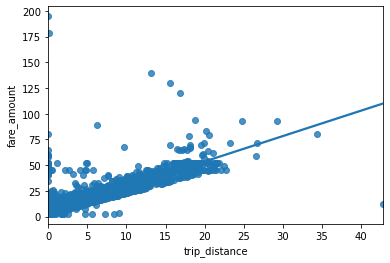

In [4]:
ax = sns.regplot(x = "trip_distance", y = "fare_amount", ci = None, truncate = True, data = trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

What's up with the streaks at \$45 and \$50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's examine whether the toll amount is captured in the total amount.

In [5]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2014-05-20 23:09:00']

pickup_datetime  pickup_longitude  pickup_latitude  \
90   2014-05-20 23:09:00+00:00        -73.873527        40.773922   
145  2014-05-20 23:09:00+00:00        -73.874567        40.774102   
201  2014-05-20 23:09:00+00:00        -74.005625        40.736770   
253  2014-05-20 23:09:00+00:00          0.000000         0.000000   
697  2014-05-20 23:09:00+00:00        -73.870160        40.760742   
753  2014-05-20 23:09:00+00:00        -73.874445        40.774037   
933  2014-05-20 23:09:00+00:00        -73.781987        40.644755   
1346 2014-05-20 23:09:00+00:00        -73.984350        40.761760   
1517 2014-05-20 23:09:00+00:00        -73.873210        40.774042   
4161 2014-05-20 23:09:00+00:00        -73.975610        40.751660   
5556 2014-05-20 23:09:00+00:00        -73.987960        40.754062   
6554 2014-05-20 23:09:00+00:00        -73.783898        40.648660   
6767 2014-05-20 23:09:00+00:00        -74.011087        40.724797   

      dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
90           -73.944947         40.828902                5           8.35   
145          -73.986480         40.759202                1          11.43   
201          -73.919840         40.877687                1          14.33   
253            0.000000          0.000000                1           6.38   
697          -73.980912         40.788492                4          10.37   
753          -73.982382         40.784930                1           9.97   
933          -73.921672         40.828412                1          19.08   
1346         -73.859030         40.718510                2          10.04   
1517         -73.978013         40.755800                5          10.45   
4161         -73.953920         40.743240                1           2.22   
5556         -73.956627         40.745962                2           3.11   
6554         -73.981845         40.762872                6          18.18   
6767         -74.026347         40.750997                1           4.09   

      tolls_amount  fare_amount  total_amount  
90            5.33         25.0         36.33  
145           5.33         37.0         54.04  
201           2.44         42.0         54.43  
253           5.33         20.0         26.33  
697           5.33         30.5         45.91  
753           5.33         30.5         44.10  
933           5.33         50.5         56.83  
1346          5.33         31.5         37.83  
1517          5.33         30.5         36.83  
4161          5.33          8.5         14.83  
5556          5.33         11.5         21.30  
6554          5.33         52.0         69.30  
6767         11.00         45.0         61.00

Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.

Let's also look at the distribution of values within the columns.

In [6]:
trips.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      10789.000000     10789.000000       10789.000000      10789.000000   
mean         -72.577466        39.988518         -72.577056         39.991694   
std           10.071200         5.523964          10.068592          5.510504   
min          -75.336579         0.000000         -75.381754          0.000000   
25%          -73.992172        40.735837         -73.991581         40.734267   
50%          -73.981871        40.753200         -73.980401         40.752872   
75%          -73.967330        40.767309         -73.964102         40.767484   
max            0.000000        41.366138           0.000000         41.366138   

       passenger_count  trip_distance  tolls_amount   fare_amount  \
count     10789.000000   10789.000000  10789.000000  10789.000000   
mean          1.648716       2.837068      0.228359     11.165192   
std           1.282589       3.319036      1.144977      9.444876   
min           0.000000       0.000000      0.000000      2.500000   
25%           1.000000       1.010000      0.000000      6.000000   
50%           1.000000       1.750000      0.000000      8.500000   
75%           2.000000       3.110000      0.000000     12.500000   
max           6.000000      42.800000     16.000000    194.750000   

       total_amount  
count  10789.000000  
mean      13.280564  
std       11.267704  
min        2.500000  
25%        7.200000  
50%       10.000000  
75%       14.600000  
max      204.750000

Hmm ... The min, max of longitude look strange.

Finally, let's actually look at the start and end of a few of the trips.

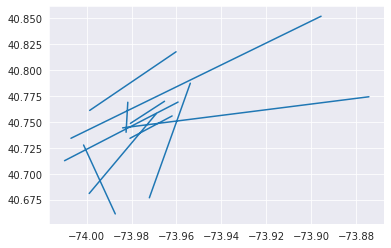

In [7]:
def showrides(df, numlines):
  import matplotlib.pyplot as plt
  lats = []
  lons = []
  goodrows = df[df['pickup_longitude'] < -70]
  for iter, row in goodrows[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  plt.plot(lons, lats)

showrides(trips, 10)

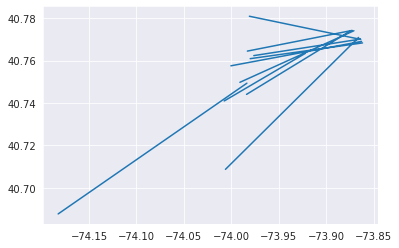

In [8]:
showrides(tollrides, 10)

In [9]:
tollrides.tolls_amount.value_counts()

5.33     153
4.80     135
4.57      80
4.15      20
5.54      18
5.50       6
11.00      6
5.00       5
8.00       4
2.44       3
10.66      2
6.00       2
13.00      2
9.50       2
10.25      2
10.00      1
10.50      1
13.75      1
7.50       1
12.00      1
14.66      1
15.00      1
9.00       1
16.00      1
1.80       1
0.50       1
14.40      1
13.33      1
15.99      1
9.14       1
11.45      1
8.30       1
6.50       1
Name: tolls_amount, dtype: int64

In [27]:
trips.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
trip_distance                    float64
tolls_amount                     float64
fare_amount                      float64
total_amount                     float64
dtype: object

In [54]:
trips['pickup_date'] = trips.pickup_datetime.dt.date
trips['pickup_year'] = trips.pickup_datetime.dt.year
trips['pickup_month'] = trips.pickup_datetime.dt.month
trips['pickup_day'] = trips.pickup_datetime.dt.day
trips['ts'] = trips.pickup_datetime.values.astype(np.int64) // 10 ** 9

In [51]:
trips.pickup_datetime.dt.

In [30]:
trips.head()

pickup_datetime  pickup_longitude  pickup_latitude  \
0 2012-05-05 22:46:05+00:00        -74.009790        40.712483   
1 2010-12-21 13:08:00+00:00        -73.982422        40.739847   
2 2011-12-03 10:28:00+00:00        -73.998822        40.680933   
3 2012-02-21 11:53:00+00:00        -73.953860        40.787055   
4 2009-09-25 03:47:00+00:00        -74.001323        40.727572   

   dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
0         -73.959293         40.768908                1           5.20   
1         -73.981658         40.768732                2           2.64   
2         -73.968960         40.757878                1           8.28   
3         -73.972072         40.676780                6          11.90   
4         -73.987230         40.661257                1           5.76   

   tolls_amount  fare_amount  total_amount pickup_date  
0           0.0         16.9         19.90  2012-05-05  
1           0.0         14.9         15.40  2010-12-21  
2           0.0         20.9         25.58  2011-12-03  
3           0.0         31.7         38.54  2012-02-21  
4           0.0         16.9         17.40  2009-09-25

In [32]:
from IPython.core.display import display, HTML

jsonstr = trips.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [10]:
tollrides

pickup_datetime  pickup_longitude  pickup_latitude  \
8     2012-02-27 09:19:10+00:00        -73.874431        40.774011   
18    2011-09-19 15:43:52+00:00        -73.872708        40.774221   
20    2012-02-21 11:53:00+00:00        -73.863943        40.770132   
25    2014-10-06 15:16:00+00:00        -73.980130        40.760910   
29    2013-12-09 15:03:00+00:00        -73.990950        40.749772   
...                         ...               ...              ...   
6840  2010-11-12 23:57:49+00:00        -73.943612        40.783491   
7329  2009-12-07 20:49:00+00:00        -73.982880        40.749430   
8459  2010-02-25 20:14:00+00:00          0.000000         0.000000   
9591  2009-05-15 07:27:09+00:00        -73.973928        40.751885   
10754 2011-12-03 10:28:00+00:00        -73.918692        40.743337   

       dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
8             -73.983967         40.744082                1          11.60   
18            -73.983089         40.764476                1          10.90   
20            -73.976330         40.762350                5          10.85   
25            -73.861730         40.768330                2          11.47   
29            -73.870807         40.774070                1           9.44   
...                  ...               ...              ...            ...   
6840          -73.971482         40.781720                1           2.10   
7329          -73.955768         40.745118                1           2.42   
8459            0.000000          0.000000                2           0.82   
9591          -73.956060         40.746063                1           2.60   
10754         -73.978595         40.741227                6           4.08   

       tolls_amount  fare_amount  total_amount  
8              4.80         27.7         38.00  
18             4.80         31.3         43.92  
20             4.80         28.5         39.50  
25             5.33         36.5         47.33  
29             5.33         29.0         34.83  
...             ...          ...           ...  
6840           4.57         45.0         60.08  
7329           4.57          7.3         14.87  
8459           0.50          6.1          7.60  
9591           4.15          9.3         15.46  
10754          4.80         12.9         18.20  

[458 rows x 10 columns]

In [67]:
dtree = DecisionTreeRegressor(max_depth= 5)

In [68]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'ts']
dtree.fit(trips[features], trips[['tolls_amount']])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

[Text(139.81704545454545, 199.32, 'dropoff_longitude <= -74.056\nmse = 1.311\nsamples = 10789\nvalue = 0.228'),
 Text(53.263636363636365, 163.07999999999998, 'pickup_longitude <= -74.044\nmse = 30.493\nsamples = 29\nvalue = 7.99'),
 Text(45.654545454545456, 126.83999999999999, 'mse = 0.0\nsamples = 6\nvalue = 0.0'),
 Text(60.872727272727275, 126.83999999999999, 'ts <= 1358217024.0\nmse = 17.447\nsamples = 23\nvalue = 10.075'),
 Text(30.436363636363637, 90.6, 'ts <= 1299648512.0\nmse = 17.67\nsamples = 12\nvalue = 7.725'),
 Text(15.218181818181819, 54.359999999999985, 'dropoff_latitude <= 40.688\nmse = 6.81\nsamples = 5\nvalue = 10.68'),
 Text(7.609090909090909, 18.119999999999976, 'mse = 0.49\nsamples = 2\nvalue = 13.7'),
 Text(22.827272727272728, 18.119999999999976, 'mse = 0.889\nsamples = 3\nvalue = 8.667'),
 Text(45.654545454545456, 54.359999999999985, 'ts <= 1333127232.0\nmse = 14.736\nsamples = 7\nvalue = 5.614'),
 Text(38.04545454545455, 18.119999999999976, 'mse = 14.222\nsamples

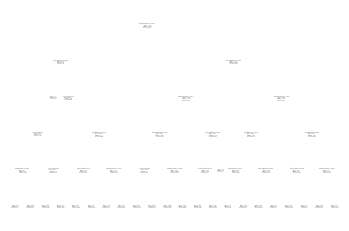

In [69]:
from sklearn.tree import plot_tree
plot_tree(dtree, feature_names= features)

In [13]:
import folium

m = folium.Map(
    location=[40.749772, -73.990950],
    zoom_start=12,
    tiles='Stamen Terrain'
)

tooltip = 'Click me!'

for r,i in tollrides[tollrides.tolls_amount == 4.80].sample(50).iterrows() : 
    p1 = [i.pickup_latitude, i.pickup_longitude]
    p2 = [i.dropoff_latitude, i.dropoff_longitude]
    folium.Marker([i.pickup_latitude, i.pickup_longitude], popup=p1, tooltip=tooltip).add_to(m)
    folium.Marker([i.dropoff_latitude, i.dropoff_longitude], popup=p2, tooltip=tooltip).add_to(m)
    folium.PolyLine(locations=[p1, p2], color='blue').add_to(m)


m

In [14]:
import folium

m = folium.Map(
    location=[40.749772, -73.990950],
    zoom_start=12,
    tiles='Stamen Terrain'
)

tooltip = 'Click me!'

for r,i in tollrides[tollrides.tolls_amount < 4.80].sample(50).iterrows() : 
    p1 = [i.pickup_latitude, i.pickup_longitude]
    p2 = [i.dropoff_latitude, i.dropoff_longitude]
    folium.Marker([i.pickup_latitude, i.pickup_longitude], popup=p1, tooltip=tooltip).add_to(m)
    folium.Marker([i.dropoff_latitude, i.dropoff_longitude], popup=p2, tooltip=tooltip).add_to(m)
    folium.PolyLine(locations=[p1, p2], color='blue').add_to(m)

m

In [18]:
import folium

m = folium.Map(
    location=[40.749772, -73.990950],
    zoom_start=12,
    tiles='Stamen Terrain'
)

tooltip = 'Click me!'

for r,i in trips.sample(100).iterrows() : 
    p1 = [i.pickup_latitude, i.pickup_longitude]
    p2 = [i.dropoff_latitude, i.dropoff_longitude]
    folium.Marker([i.pickup_latitude, i.pickup_longitude], popup=p1, tooltip=tooltip).add_to(m)
    folium.Marker([i.dropoff_latitude, i.dropoff_longitude], popup=p2, tooltip=tooltip).add_to(m)
    color = 'red' if i.tolls_amount >0 else 'blue'
    folium.PolyLine(locations=[p1, p2], color=color).add_to(m)

m

In [24]:
tollrides.iterrows[tollrides.tolls_amount == 4.80]

pickup_datetime  pickup_longitude  pickup_latitude  \
9     2012-02-21 11:53:00+00:00        -73.862780        40.769055   
20    2012-02-27 09:19:10+00:00        -73.874431        40.774011   
21    2012-02-21 11:53:00+00:00        -73.863943        40.770132   
69    2012-11-19 17:41:00+00:00        -73.870992        40.773690   
94    2012-01-25 19:38:12+00:00        -73.874582        40.773995   
...                         ...               ...              ...   
6834  2011-12-02 10:32:11+00:00        -73.776839        40.645364   
6835  2012-02-21 11:53:00+00:00        -73.784000        40.648662   
6836  2012-07-26 20:53:20+00:00        -73.845174        40.738697   
6837  2012-06-02 02:02:11+00:00        -73.786656        40.641802   
10779 2011-12-03 10:28:00+00:00        -73.918692        40.743337   

       dropoff_longitude  dropoff_latitude  passenger_count  trip_distance  \
9             -74.000443         40.757547                1          10.06   
20            -73.983967         40.744082                1          11.60   
21            -73.976330         40.762350                5          10.85   
69            -73.973320         40.736715                1           9.23   
94            -73.986147         40.758647                1          11.30   
...                  ...               ...              ...            ...   
6834          -73.991287         40.750092                2          17.70   
6835          -73.975317         40.757567                1          18.22   
6836          -73.977652         40.777101                1          12.60   
6837          -73.983443         40.744292                1          17.40   
10779         -73.978595         40.741227                6           4.08   

       tolls_amount  fare_amount  total_amount  
9               4.8         31.3         42.86  
20              4.8         27.7         38.00  
21              4.8         28.5         39.50  
69              4.8         31.0         37.30  
94              4.8         27.7         34.00  
...             ...          ...           ...  
6834            4.8         45.0         50.30  
6835            4.8         45.0         50.30  
6836            4.8         45.0         50.30  
6837            4.8         45.0         50.30  
10779           4.8         12.9         18.20  

[135 rows x 10 columns]

In [20]:
from IPython.core.display import display, HTML

jsonstr = tollrides.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

As you'd expect, rides that involve a toll are longer than the typical ride.

<h3> Quality control and other preprocessing </h3>

We need to do some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

Let's change the BigQuery query appropriately.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

In [70]:
def sample_between(a, b):
    basequery = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
    sampler = "AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N)) = 1"
    sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), EVERY_N * 100))",
           "(EVERY_N * {})".format(a), "(EVERY_N * {})".format(b)
        )
    return "{}\n{}\n{}".format(basequery, sampler, sampler2)

def create_query(phase, EVERY_N):
  """Phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    # Training
    query = sample_between(0, 70)
  elif phase == 'valid':
    # Validation
    query = sample_between(70, 85)
  else:
    # Test
    query = sample_between(85, 100)
  return query.replace("EVERY_N", str(EVERY_N))

print(create_query('train', 100000))


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  
AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000 * 100)) >= (100000 * 0)
 AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000 * 100)) < (100000 * 70)


In [71]:
def to_csv(df, filename):
  outdf = df.copy(deep = False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # Reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print(cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header = False, index_label = False, index = False)
  print("Wrote {} to {}".format(len(outdf), filename))

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 100000)
  df = bigquery.Client().query(query).to_dataframe()
  to_csv(df, 'taxi-{}.csv'.format(phase))

['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 7645 to taxi-train.csv
['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 1814 to taxi-valid.csv
['fare_amount', 'pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers', 'key']
Wrote 1017 to taxi-test.csv


<h3> Verify that datasets exist </h3>

In [72]:
!ls -l *.csv

-rw-r--r-- 1 jupyter jupyter  58048 Apr 15 08:57 taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 434648 Apr 15 08:57 taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 102591 Apr 15 08:57 taxi-valid.csv


We have 3 .csv files corresponding to train, valid, test.  The ratio of file-sizes correspond to our split of the data.

In [73]:
!head taxi-train.csv

6.5,-73.981565,40.732902,-73.989255,40.748087,1.0,0
7.5,-73.977417,40.757775,-73.98744,40.745502,1.0,1
8.5,-73.952977,40.780286,-73.947307,40.811909,1.0,2
9.0,-73.978015,40.76337,-73.981373,40.784517,1.0,3
17.0,-73.976362,40.751972,-74.009268,40.701627,4.0,4
14.1,-73.98893,40.726817,-73.954809,40.725432,2.0,5
6.5,-73.95782,40.765328,-73.970487,40.764013,1.0,6
9.5,-73.969198,40.761112,-73.951095,40.777562,6.0,7
5.3,-73.98237,40.743422,-73.97601,40.74889,4.0,8
12.1,-73.982652,40.739502,-73.982621,40.771564,2.0,9


Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

<h3> Benchmark </h3>

Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

My model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict.  Let's compute the RMSE of such a model.

In [ ]:
import pandas as pd
import numpy as np
import shutil

def distance_between(lat1, lon1, lat2, lon2):
  # Haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual - predicted)**2))

def print_rmse(df, rate, name):
  print("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate * estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header = None, names = columns)
df_valid = pd.read_csv('taxi-valid.csv', header = None, names = columns)
df_test = pd.read_csv('taxi-test.csv', header = None, names = columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

The simple distance-based rule gives us a RMSE of <b>$9.35</b> on the validation dataset.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat. You don't wnat to set a goal on the test dataset because you want to change the architecture of the network etc. to get the best validation error. Then, you can evaluate ONCE on the test data.

## Challenge Exercise

Let's say that you want to predict whether a Stackoverflow question will be acceptably answered. Using this [public dataset of questions](https://bigquery.cloud.google.com/table/bigquery-public-data:stackoverflow.posts_questions), create a machine learning dataset that you can use for classification.
<p>
What is a reasonable benchmark for this problem?
What features might be useful?
<p>
If you got the above easily, try this harder problem: you want to predict whether a question will be acceptably answered within 2 days. How would you create the dataset?
<p>
Hint (highlight to see):
<p style='color:white' linkstyle='color:white'> 
You will need to do a SQL join with the table of [answers]( https://bigquery.cloud.google.com/table/bigquery-public-data:stackoverflow.posts_answers) to determine whether the answer was within 2 days.
</p>

Copyright 2018 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.